# The Curse of the Data Analyst

## Springboard (the 2nd best rated Data Science Bootcamp in 2019, source: https://www.switchup.org/rankings/best-data-science-bootcamps) lists Data Scientist, Data Analyst, and Data Engineer as core data science roles. This notebook will examine the latter two job titles and answer the following which helps aspiring Data Scientists, recruiters, and employers:
### (1) Is there salary discrimination against women in these core data science roles?
### (2) What is the curse of the Data Analyst?

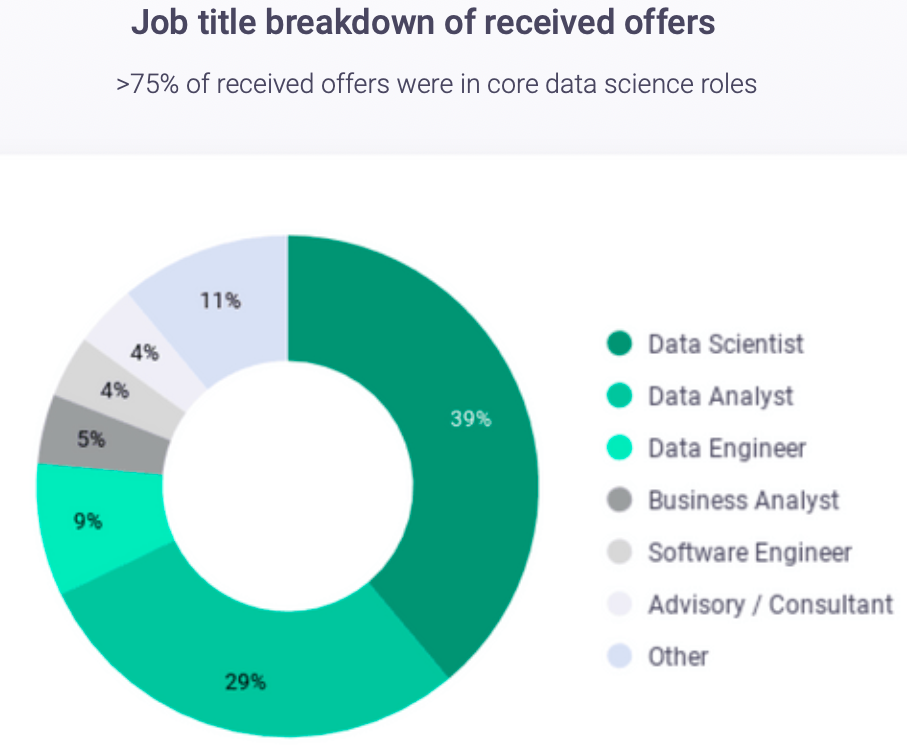

In [1]:
from IPython.display import Image
Image("/Users/victor/Desktop/SpringBoard/Job_Title_Breakdown.png")
# source: https://workshops.springboard.com/student-outcomes/

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Data taken from the 2018 Kaggle Data Science survery in this notebook is limited to those who: 
## (1) live in the USA, 
## (2) share their salary details, 
## (3) are employed, and 
## (4) are Data Scientists or Data Analysts

In [3]:
df = pd.read_csv("/Users/victor/Downloads/kaggle-survey-2018/multipleChoiceResponses.csv",skiprows=1)

# 1
df = df.loc[df["In which country do you currently reside?"]=="United States of America"]

# Cleaning up the labels
df = df.iloc[:,[1,3,5,6,7,9,11,12]]
df.columns = ["Gender","Age","Education","Major",
              "Occupation","Industry","Experience",
              "Salary"]

# 2 and 3
df = df.dropna(subset=['Salary'])
df = df[~df.isin(['I am a student', 
                  'I do not wish to disclose my approximate yearly compensation',
                  'Student',
                  'Not employed']).any(axis=1)]

# 4
df = df[(df.Occupation=="Data Scientist") | 
        (df.Occupation=="Data Analyst")]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 11 to 23652
Data columns (total 8 columns):
Gender        1098 non-null object
Age           1098 non-null object
Education     1098 non-null object
Major         1097 non-null object
Occupation    1098 non-null object
Industry      1098 non-null object
Experience    1098 non-null object
Salary        1098 non-null object
dtypes: object(8)
memory usage: 77.2+ KB


# There was 1 individual with a missing Major
## They were dropped;

In [4]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1097 entries, 11 to 23652
Data columns (total 8 columns):
Gender        1097 non-null object
Age           1097 non-null object
Education     1097 non-null object
Major         1097 non-null object
Occupation    1097 non-null object
Industry      1097 non-null object
Experience    1097 non-null object
Salary        1097 non-null object
dtypes: object(8)
memory usage: 77.1+ KB


# Adding Salary, Age, and Experience continuous features for a linear regression model

In [5]:
#Salary
dictionary = {'0-10,000'    : 5000,
              '10-20,000'   : 15000,
              '20-30,000'   : 25000,
              '30-40,000'   : 35000,
              '40-50,000'   : 45000,
              '50-60,000'   : 55000,
              '60-70,000'   : 65000,
              '70-80,000'   : 75000,
              '80-90,000'   : 85000,
              '90-100,000'  : 95000,
              '100-125,000' : 112500,
              '125-150,000' : 137500,
              '150-200,000' : 175000,
              '200-250,000' : 225000,
              '250-300,000' : 275000,
              '300-400,000' : 350000,
              '400-500,000' : 450000,
              '500,000+'    : 500000
             }
df['Salary_Mid'] = df['Salary'].apply(lambda x: dictionary[x])

#Age
dictionary = {'18-21' : 19.5,
              '22-24' : 23,
              '25-29' : 27,
              '30-34' : 32,
              '35-39' : 37,
              '40-44' : 42,
              '45-49' : 47,
              '50-54' : 52,
              '55-59' : 57,
              '60-69' : 64.5,
              '70-79' : 74.5,
              '80+'   : 80
             }
df['Age_Mid'] = df['Age'].apply(lambda x: dictionary[x])

#Experience
dictionary = {'0-1'    : .5,
              '1-2'    : 1.5,
              '2-3'    : 2.5,
              '3-4'    : 3.5,
              '4-5'    : 4.5,
              '5-10'   : 7.5,
              '10-15'  : 12.5,
              '15-20'  : 17.5,
              '20-25'  : 22.5,
              '25-30'  : 27.5,
              '30 +'   : 30
            }
df['Experience_Mid'] = df['Experience'].apply(lambda x: dictionary[x])

# Shortening of some labels

In [6]:
dictionary = {'Male'                    : 'Male',
              'Female'                  : 'Female',
              'Prefer not to say'       : 'Unknown', 
              'Prefer to self-describe' : 'Self-Describe'
             }
df.Gender = df.Gender.apply(lambda x: dictionary[x])

dictionary = {'Master’s degree'                                                  : "Master's", 
              'Bachelor’s degree'                                                : "Bachelor's",
              'Some college/university study without earning a bachelor’s degree': 'No Degree',
              'Doctoral degree'                                                  : 'Doctoral', 
              'Professional degree'                                              : 'Professional', 
              'I prefer not to answer'                                           : 'Unknown'
             }
df.Education = df.Education.apply(lambda x: dictionary[x])

dictionary = {'Social sciences (anthropology, psychology, sociology, etc.)'   : 'Social Sci',
              'Mathematics or statistics'                                     : 'Math/Stats', 
              'Engineering (non-computer focused)'                            : 'Engineering',
              'Computer science (software engineering, etc.)'                 : 'Comp Sci',
              'Physics or astronomy'                                          : 'Phys/Astron',
              'A business discipline (accounting, economics, finance, etc.)'  : 'Business',
              'Medical or life sciences (biology, chemistry, medicine, etc.)' : 'Medic Sci',
              'Fine arts or performing arts'                                  : 'Art',
              'Information technology, networking, or system administration'  : 'IT',
              'Environmental science or geology'                              : 'Envir Sci', 
              'Other'                                                         : 'Other',
              'Humanities (history, literature, philosophy, etc.)'            : 'Humanities',
              'I never declared a major'                                      : "No Major"
             }
df['Major'] = df['Major'].apply(lambda x: dictionary[x])

dictionary = {'Other'                                  : "Other",
              'Marketing/CRM'                          : "Marketing", 
              'Insurance/Risk Assessment'              : "Risk_Asse",
              'Computers/Technology'                   : "Technology", 
              'Broadcasting/Communications'            : "Communication",
              'Academics/Education'                    : "Education", 
              'Accounting/Finance'                     : "Finance",
              'Medical/Pharmaceutical'                 : "Medical", 
              'Non-profit/Service'                     : "Non-Profit",
              'Online Service/Internet-based Services' : "Online_Serv",
              'Shipping/Transportation'                : "Transport", 
              'Energy/Mining'                          : "Energy", 
              'Retail/Sales'                           : "Sales" ,
              'Military/Security/Defense'              : "Military",
              'Online Business/Internet-based Sales'   : "Online_Sales",
              'Manufacturing/Fabrication'              : "Manufacturing", 
              'Government/Public Service'              : "Government",
              'Hospitality/Entertainment/Sports'       : "Entertainment"
             }
df['Industry'] = df['Industry'].apply(lambda x: dictionary[x])

# Reordering and reducing the columns

In [7]:
df = df[["Occupation","Gender","Education","Major","Industry","Age","Experience","Salary","Age_Mid","Experience_Mid","Salary_Mid"]]

# Count Plots

## Because there are so few non-(fe)male, should they be removed for purely graph-related aesthetics?

## Same for non-bachelors, masters, doctoral

## Are there standards for removing certain subgroups from graphs? (for example less than 5% of group, etc.)

In [8]:
def pie(column):
    labels = df[column].value_counts().index
    values = df[column].value_counts()
    colors = ['#66b3ff', '#ff9999', '#77dd77', '#fdfd96', '#ff6961', 
              '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
              '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', 
              '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', 
              '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff',]
    marker = dict(colors=colors,line=dict(color='#FFF', width=2))
    font = dict(size=16, color='#7f7f7f')
    layout = go.Layout(height = 700,
                       width = 1000,
                       autosize = False,
                       title = ("Pie Chart of " + column),
                       font = font)

    fig = go.Figure(data=[go.Pie(labels=labels, values=values, marker=marker, showlegend=False, textinfo='label+percent')], layout=layout)
    fig.show()

for label in df.columns[:8]:
    pie(label)

# (1) Is there salary discrimination against women in these core data science roles?

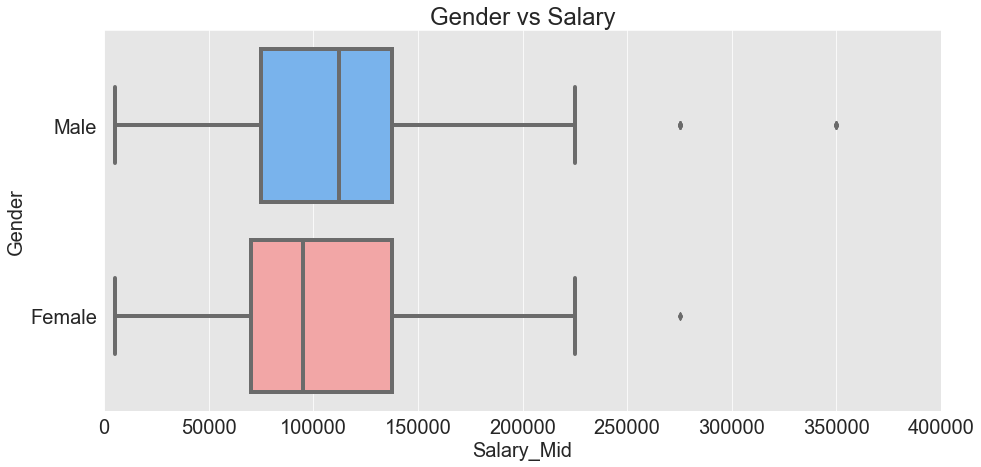

In [17]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(15, 7))
mpl.rcParams['font.size'] = 20

hue_df = (df[(df.Gender=="Male") | (df.Gender=="Female")])
palette = ['#66b3ff','#ff9999']
sns.boxplot(x=hue_df.Salary_Mid, y=hue_df.Gender,
            linewidth = 4, palette=palette)
plt.xlim(0,400000)
plt.title("Gender vs Salary")
plt.show()

In [10]:
def ttest(x,y,df_column):
    t, p = stats.ttest_ind(df.Salary_Mid[df[df_column]==x],
                          df.Salary_Mid[df[df_column]==y], equal_var = False)
    print (x, "vs", y, "p-value:",p)

ttest("Male","Female","Gender")    

Male vs Female p-value: 7.804893117817954e-07


# It appears men are making significantly (statisically speaking) more money than women. But let's see if Simpson's paradox is occuring by examining two other variables through the gender lense.

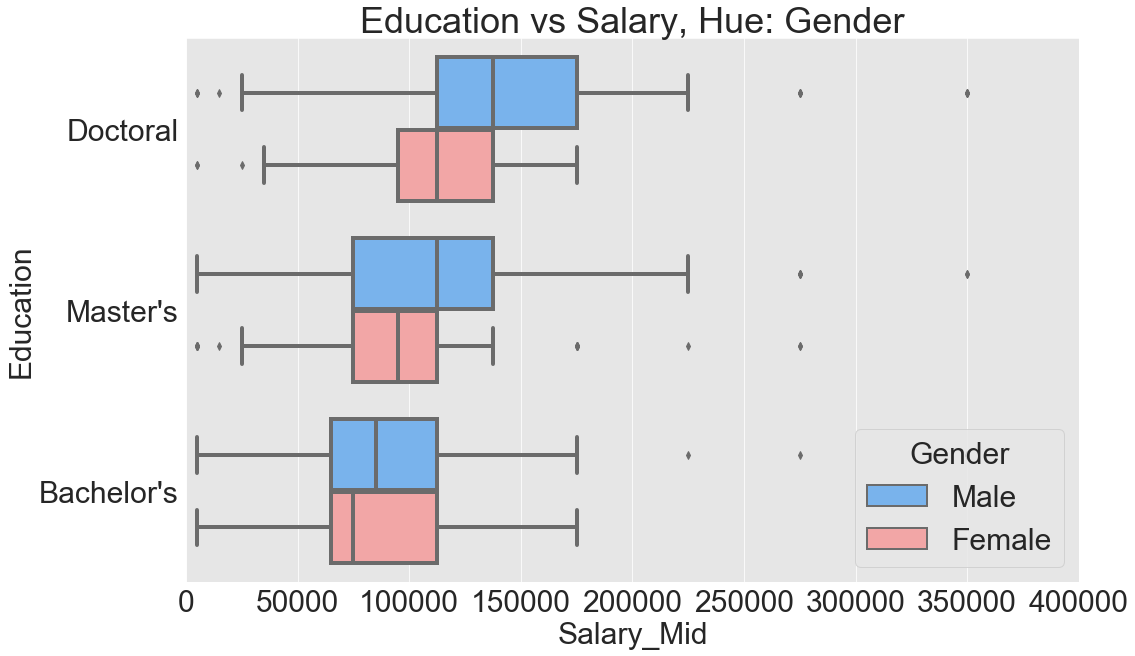

In [19]:
plt.figure(figsize=(16, 10))
mpl.rcParams['font.size'] = 30

hue_df = (df[(df.Gender=="Male") | (df.Gender=="Female")])
palette = ['#66b3ff','#ff9999']
sns.boxplot(x=hue_df.Salary_Mid, y=hue_df.Education,
            hue=hue_df.Gender, linewidth = 4, palette=palette,
            order = (["Doctoral","Master's","Bachelor's"]))

plt.xlim(0,400000)
plt.title("Education vs Salary, Hue: Gender")
plt.show()

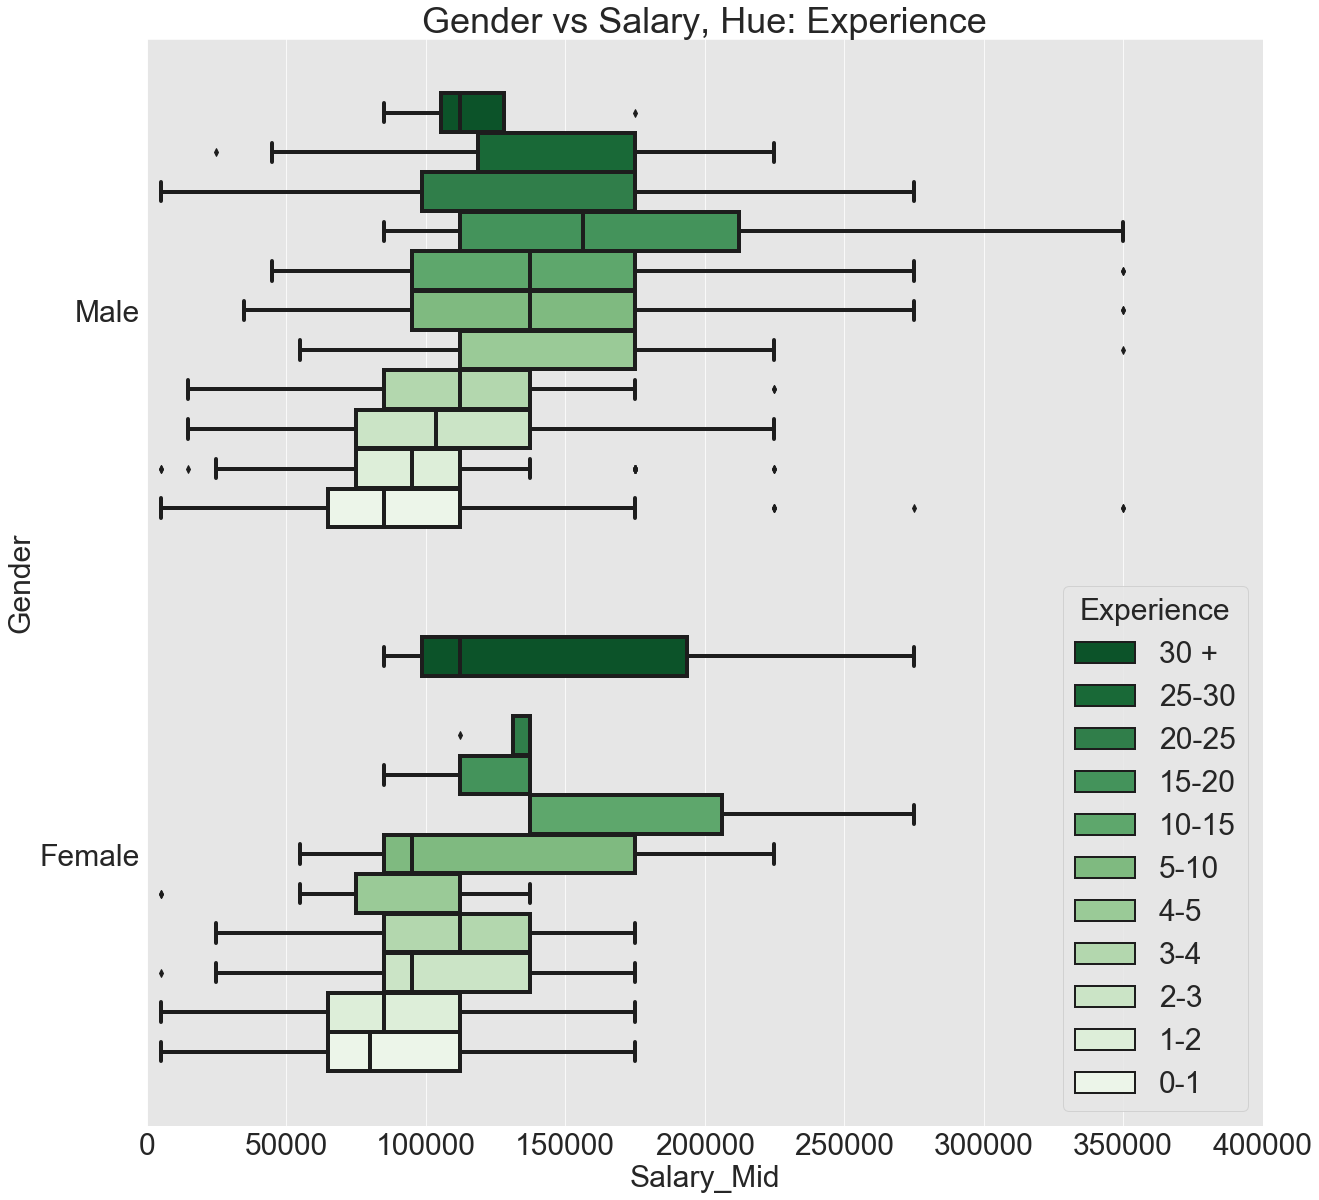

In [12]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(20, 20))
mpl.rcParams['font.size'] = 30

hue_df = (df[(df.Gender=="Male") | (df.Gender=="Female")])
palette = "Greens_r"
sns.boxplot(x=hue_df.Salary_Mid, y=hue_df.Gender,
            hue=hue_df.Experience, linewidth = 4, palette=palette,
            hue_order = (['30 +','25-30','20-25','15-20','10-15','5-10','4-5','3-4','2-3','1-2','0-1'])
           )

plt.xlim(0,400000)
plt.title("Gender vs Salary, Hue: Experience")
plt.show()

# (1) There is salary discrimination against women in these core data science roles.
## The Education graph shows that despite having equivalent degrees, women make consistently less than men. 
## The Experience graph shows women's salary tends to stagnant despite increasing experience, whereas men's salary increases in relation to their number of years of experience predictably.

# What is the Curse of the Data Analyst?

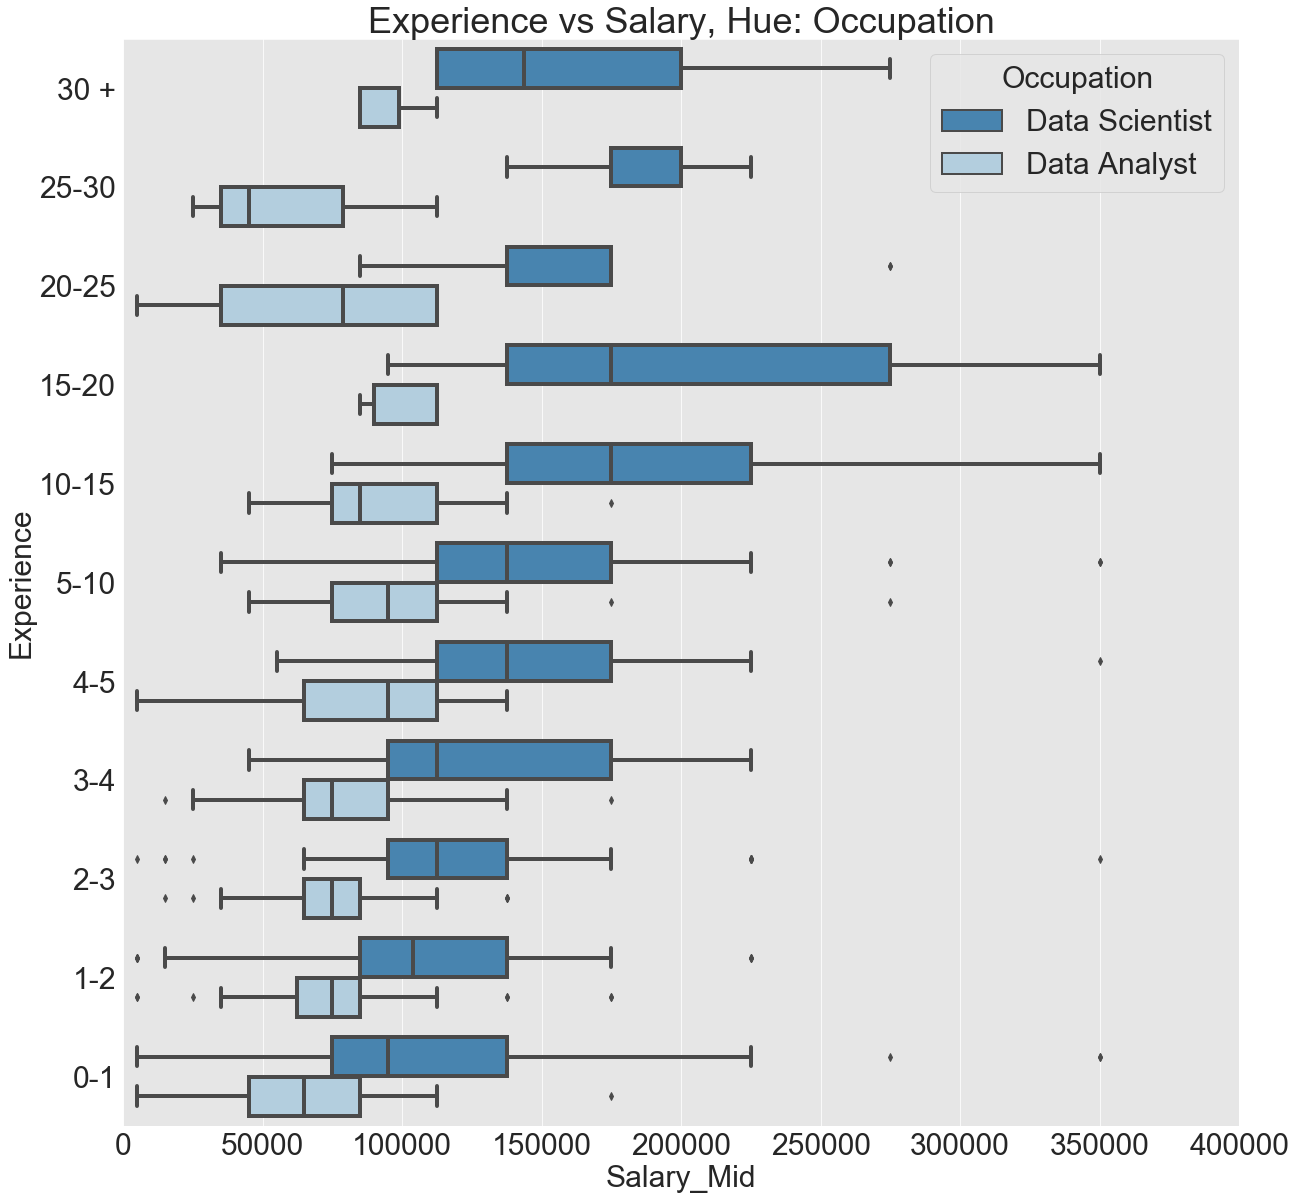

In [13]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(20, 20))
mpl.rcParams['font.size'] = 30

palette = "Blues_r"
sns.boxplot(x=df.Salary_Mid, y=df.Experience,
            hue=df.Occupation, linewidth = 4, palette=palette,
            order = (['30 +','25-30','20-25','15-20','10-15','5-10','4-5','3-4','2-3','1-2','0-1']))

plt.xlim(0,400000)
plt.title("Experience vs Salary, Hue: Occupation")
plt.show()

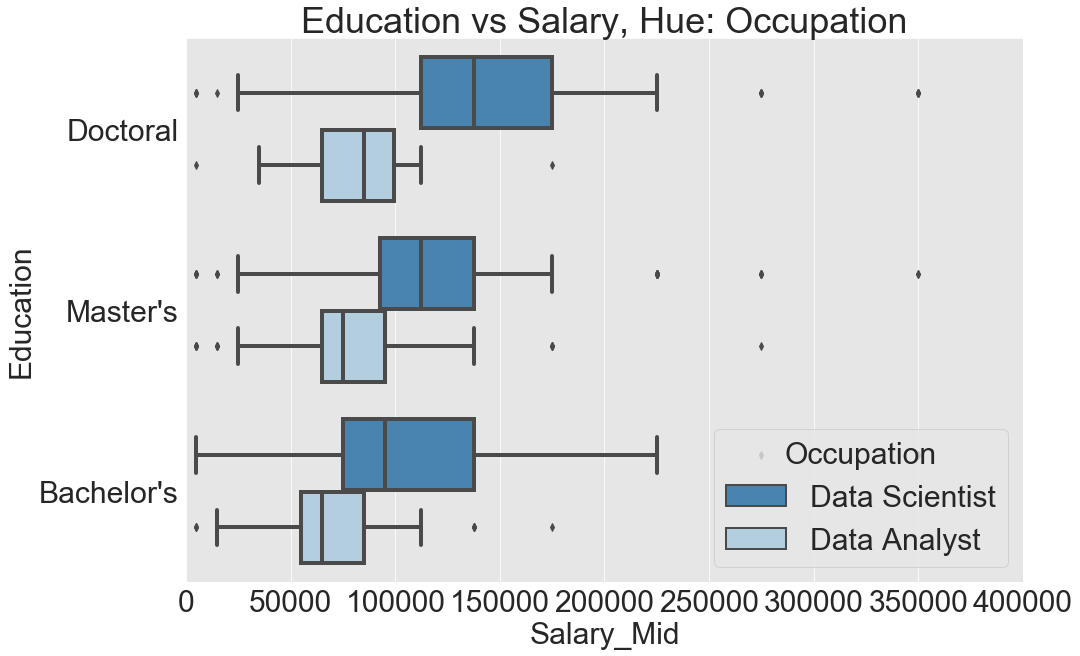

In [16]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(15, 10))
mpl.rcParams['font.size'] = 30

palette = "Blues_r"
sns.boxplot(x=df.Salary_Mid, y=df.Education,
            hue=df.Occupation, linewidth = 4, palette=palette,
            order = (["Doctoral","Master's","Bachelor's"]))

plt.xlim(0,400000)
plt.title("Education vs Salary, Hue: Occupation")
plt.show()

In [15]:
def edu_ttest(df_column,x,y,z):
    less_df = df[df.Education==y]
    more_df = df[df.Education==z]
    t,p = stats.ttest_ind(less_df.Salary_Mid[less_df[df_column]==x],
                          more_df.Salary_Mid[more_df[df_column]==x], equal_var = False)
    print(y,"vs",z,"p-value:",p)

edu_ttest("Occupation","Data Analyst","Bachelor's","Master's")
edu_ttest("Occupation","Data Analyst","Master's","Doctoral")    
edu_ttest("Occupation","Data Analyst","Bachelor's","Doctoral")    

Bachelor's vs Master's p-value: 0.05005406405362446
Master's vs Doctoral p-value: 0.8491185719382108
Bachelor's vs Doctoral p-value: 0.28875448907660584


# The curse is three-fold. First, median salary never crosses the 100,000 dollar threshold--even with 30 years of experience. Second, Data Analysts typically cap their maximum salary between 4-5 years of experience. Third, having an advanced degree does little in terms of salary.

## (However, happiness related to financial security maxes with a 75,000 dollar salary, source: https://blogs.wsj.com/wealth/2010/09/07/the-perfect-salary-for-happiness-75000-a-year/)

# Findings:
## Discrimination against women in core data science roles exists and both job-seekers and employers should seek to rectify this issue.
## The Curse of the Data Analyst suggests that one should not stay in that role for more than 5 years if a salary beyond 100,000 dollars is desired.